In [1]:
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [20]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.3.4


In [4]:
data_dir = 'asl_alphabet_train'

list_ds = tf.data.Dataset.list_files(str(data_dir + '/*/*.jpg'), shuffle=False)
image_count = len(list_ds)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True)

class_names = np.array(sorted([item.name for item in os.scandir(data_dir)]))
num_classes = len(class_names)

In [5]:
print(f"The total number of images in the dataset is {image_count}.")
print(f"The number of different classes is {num_classes}.")

The total number of images in the dataset is 87000.
The number of different classes is 29.


In [21]:
batch_size = 10
img_height = 200
img_width = 200
channel = 1

In [22]:
# # Splitting into training and validation sets
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [23]:
def preprocess_image(file_path):
    # Load the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=channel)
    img = tf.image.resize(img, [img_height, img_width])

    # Data augmentation
    img = tf.image.random_flip_left_right(img)  # Randomly flip the image left to right
    img = tf.image.random_flip_up_down(img)  # Randomly flip the image upside down
    img = tf.image.random_brightness(img, max_delta=0.1)  # Randomly adjust the brightness
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)  # Randomly adjust the contrast

    # # Rescale pixel values
    img /= 255.0
    return img

In [24]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == class_names

In [25]:
train_ds = train_ds.map(lambda x: (preprocess_image(x), get_label(x)),
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

val_ds = val_ds.map(lambda x: (preprocess_image(x), get_label(x)),
                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)

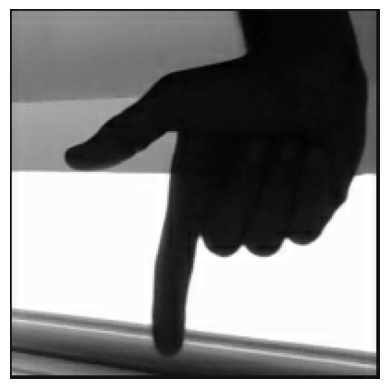

In [26]:
image, label = next(iter(val_ds.take(2)))

# Access the label of the first example
first_label = image[0]

plt.imshow(first_label, cmap="gray")
plt.axis('off')
plt.show()

In [27]:
model = Sequential()

# Add the layers to the model with the specified input shape
model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(img_height, img_width, channel), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
# Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 50, 50, 96)        11712     
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 50, 96)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 256)       614656    
_________________________________________________________________
batch_normalization_3 (Batch (None, 24, 24, 256)       1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 384)      

In [29]:
# Define early stopping criteria
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=3,           # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore model weights to those that achieved the best value of the monitored metric
)

# Train the model with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping]  # Include early stopping callback
)

Epoch 1/10
6960/6960 [==============================] - 268s 39ms/step - loss: 1.8545 - accuracy: 0.4219 - val_loss: 1.0729 - val_accuracy: 0.6524
Epoch 2/10
6960/6960 [==============================] - 269s 39ms/step - loss: 0.4991 - accuracy: 0.8288 - val_loss: 0.2201 - val_accuracy: 0.9303
Epoch 3/10
6960/6960 [==============================] - 270s 39ms/step - loss: 0.2352 - accuracy: 0.9196 - val_loss: 0.1056 - val_accuracy: 0.9657
Epoch 4/10
6960/6960 [==============================] - 288s 41ms/step - loss: 0.1390 - accuracy: 0.9531 - val_loss: 0.0813 - val_accuracy: 0.9721
Epoch 5/10
6960/6960 [==============================] - 280s 40ms/step - loss: 0.0957 - accuracy: 0.9693 - val_loss: 0.0653 - val_accuracy: 0.9813
Epoch 6/10
6960/6960 [==============================] - 269s 39ms/step - loss: 0.0703 - accuracy: 0.9771 - val_loss: 0.1013 - val_accuracy: 0.9676
Epoch 7/10
6960/6960 [==============================] - 269s 39ms/step - loss: 0.0504 - accuracy: 0.9837 - val_loss: 0

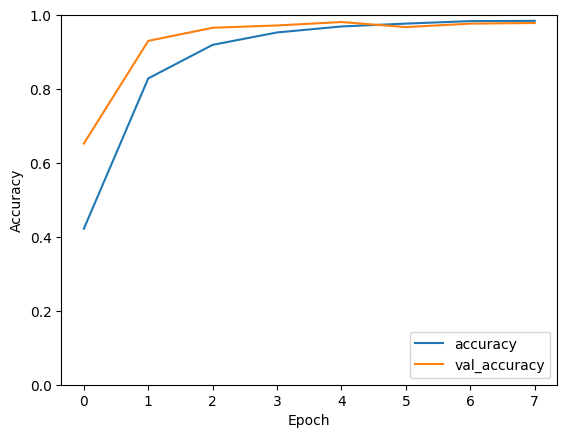

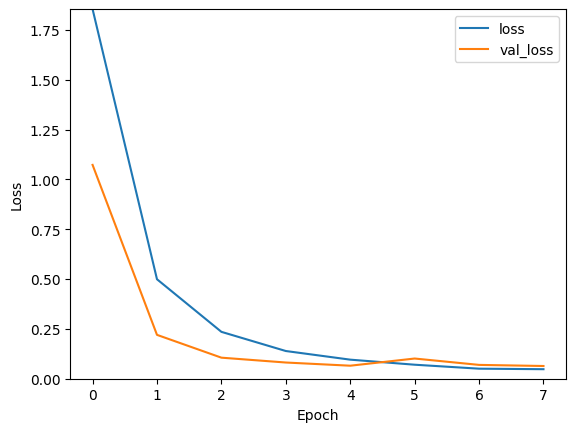

In [30]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, max(np.max(history.history['loss']), np.max(history.history['val_loss']))])
plt.legend(loc='upper right')
plt.show()

In [31]:
evaluation = model.evaluate(val_ds)

# Print the evaluation results
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])

1740/1740 [==============================] - 39s 22ms/step - loss: 0.0663 - accuracy: 0.9807
Validation Loss: 0.06633175909519196
Validation Accuracy: 0.9807471036911011


              precision    recall  f1-score   support

           0       0.95      0.98      0.97       596
           1       0.98      0.98      0.98       593
           2       0.99      1.00      0.99       620
           3       0.98      1.00      0.99       539
           4       0.98      0.96      0.97       570
           5       1.00      1.00      1.00       638
           6       1.00      1.00      1.00       604
           7       0.98      0.99      0.99       623
           8       0.99      0.98      0.99       609
           9       0.98      0.99      0.98       563
          10       0.98      0.99      0.98       571
          11       0.99      1.00      1.00       629
          12       0.99      0.95      0.97       623
          13       0.99      0.95      0.97       584
          14       0.99      0.98      0.99       641
          15       0.98      0.99      0.99       569
          16       0.99      0.98      0.99       590
          17       0.95    

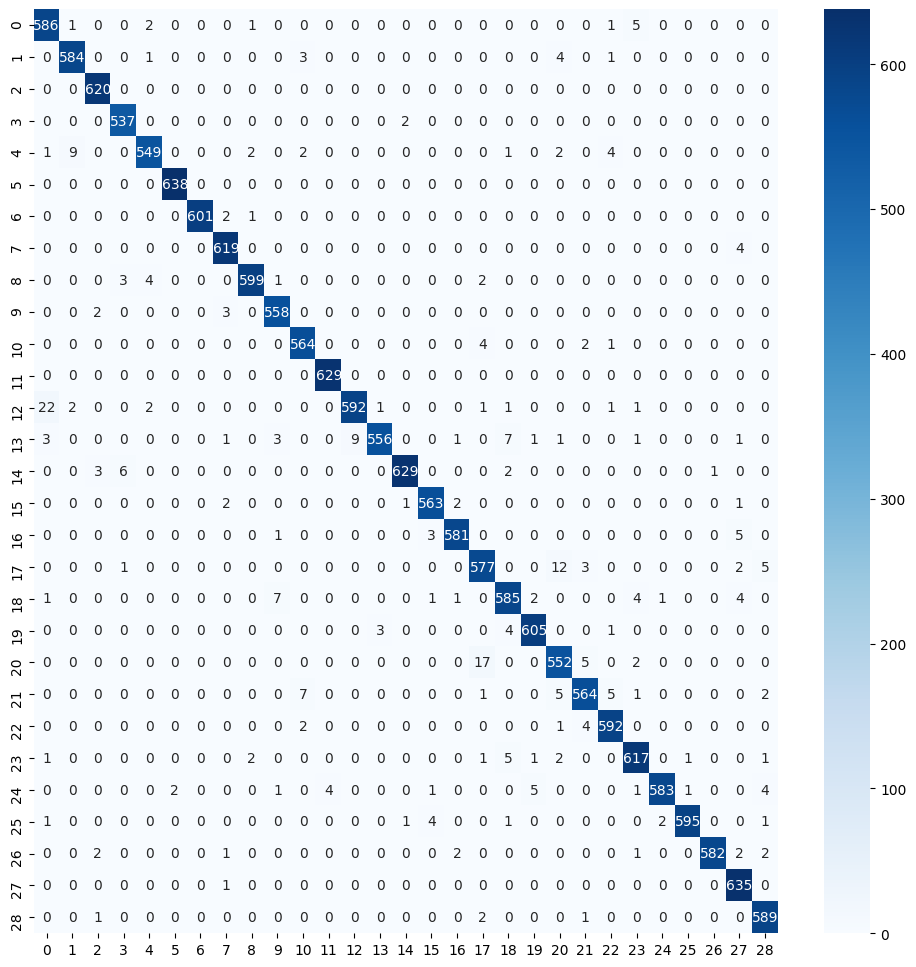

In [32]:
# Initialize empty lists to store true labels and predictions
true_labels = []
predictions = []

# Iterate over the test dataset to extract true labels and predictions
for images, labels in val_ds:
    true_labels.extend(np.argmax(labels, axis=1))  # Convert one-hot encoded labels to categorical labels
    predictions.extend(np.argmax(model.predict(images), axis=1))  # Get predictions

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Print classification report
print(classification_report(true_labels, predictions))

# Plot confusion matrix
plt.figure(figsize=(12, 12))
sns.heatmap(confusion_matrix(true_labels, predictions), annot=True, fmt="d", cmap="Blues")
plt.show()

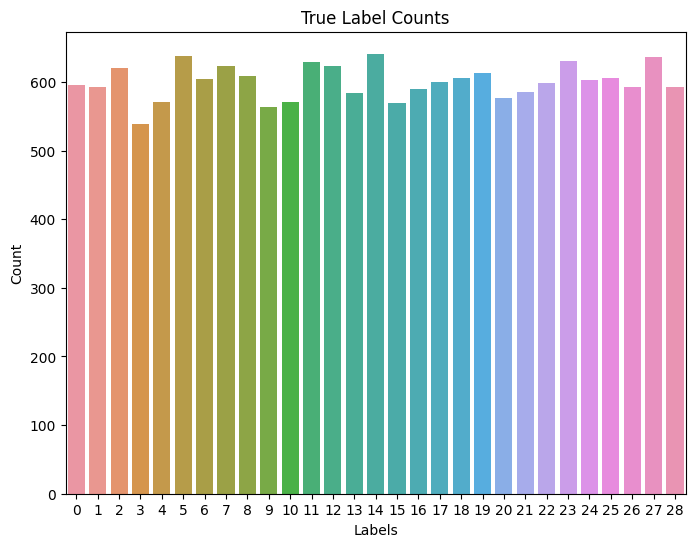

In [37]:
# Plot label counts
plt.figure(figsize=(8, 6))
sns.countplot(x=true_labels)
plt.title('True Label Counts')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [35]:
model.save("sign_language.h5")

In [38]:
os.makedirs("model", exist_ok=True)

# Now you can save your files in this directory
model_json = model.to_json()
with open("model/model_sign.json", "w") as json_file:
    json_file.write(model_json)
print('Model Saved')
model.save_weights('model/model_sign.h5')
print('Weights saved')

Model Saved
Weights saved
